In [49]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import math
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from scipy.stats import uniform,norm
import matplotlib.pyplot as plt
import scipy.stats as sct
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from skimage import morphology
from skimage.draw import polygon

In [2]:
def read_structure(structure):
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        if i == 3:
            contour = {}
            contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
            contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber ##
            contour['name'] = structure.StructureSetROISequence[i].ROIName
            contour['number'] == structure.StructureSetROISequence[i].ROINumber
            contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
            contours.append(contour)
    return contours

def get_mask(contours, slices):
    z = [round(s.ImagePositionPatient[2],1) for s in slices] ##
    #print(z)
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    for con in contours:
        num = int(con['number'])
        
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3)) #triplets describing points of contour
            #assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(np.around(nodes[0, 2], 1))
            #print(np.around(nodes[0, 2], 1))
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num
            #con['color'] = [0, 0, 255] 
            colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors

In [37]:
contour_path="Prostate Cases/9/rtss.dcm"
img_path="Prostate Cases/9/ct"

In [38]:
#read img and contour
contour=pydicom.read_file(contour_path)
contours=read_structure(contour)
slices = [pydicom.read_file(img_path + '/' + s) for s in os.listdir(img_path)]
image = np.stack([s.pixel_array for s in slices], axis=-1)
label, colors = get_mask(contours, slices)

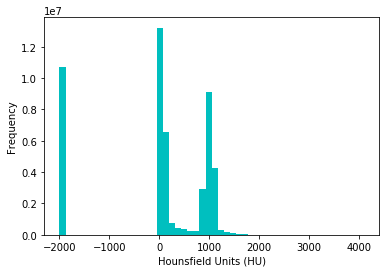

In [39]:
plt.hist(image.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [40]:
print("Slice Thickness: %f" % slices[8].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (slices[8].PixelSpacing[0], slices[8].PixelSpacing[1]))

Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.976562, 0.976562) 


C:\Users\73707\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


(-0.5, 511.5, 511.5, -0.5)

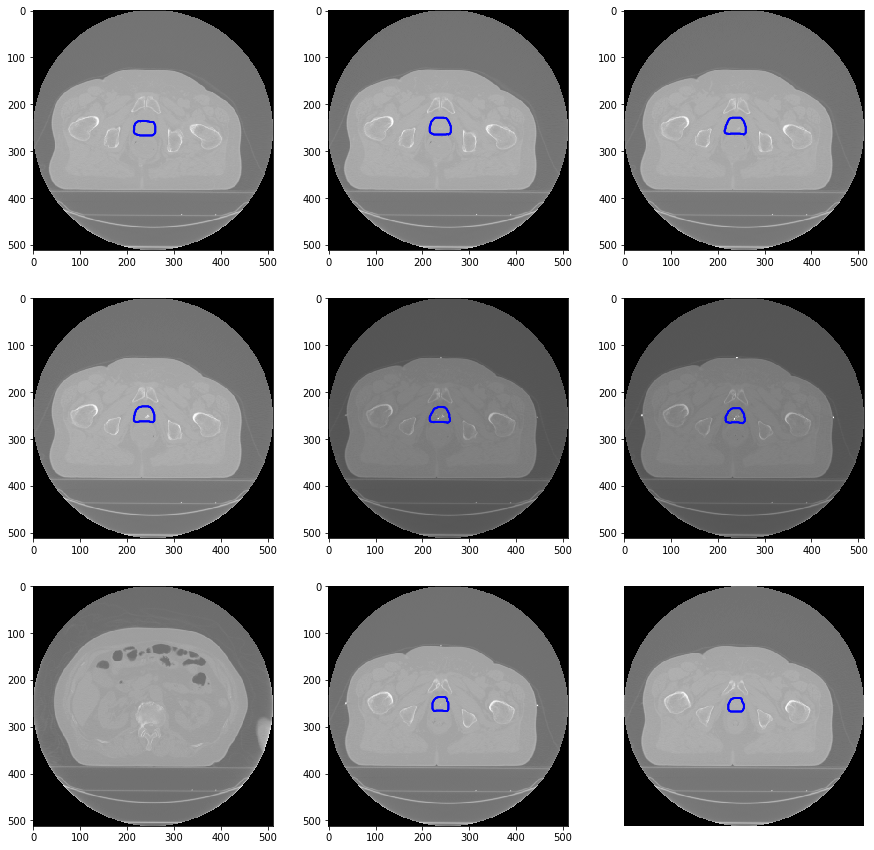

In [54]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i  + 18 ], cmap="gray")
    plt.contour(label[..., i + 18 ], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.axis('off')

[0 4]


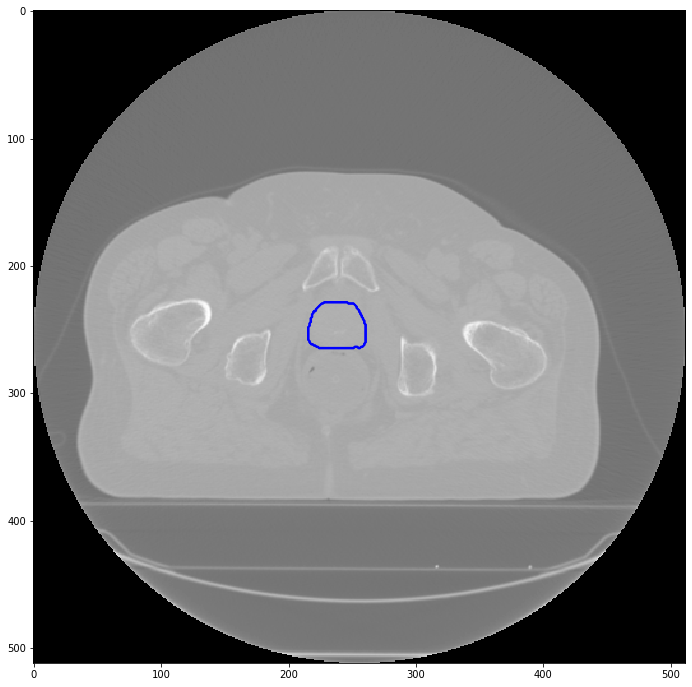

In [57]:

target_img = image[..., 19]
target_label = label[..., 19]
print(np.unique(target_label))
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(target_img, cmap="gray")
plt.contour(target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.show()

In [120]:
#blur the img
from scipy.ndimage import gaussian_filter
blur1=gaussian_filter(target_img, sigma=5)
import cv2
blur2 = cv2.GaussianBlur(target_img,(11,11),0)

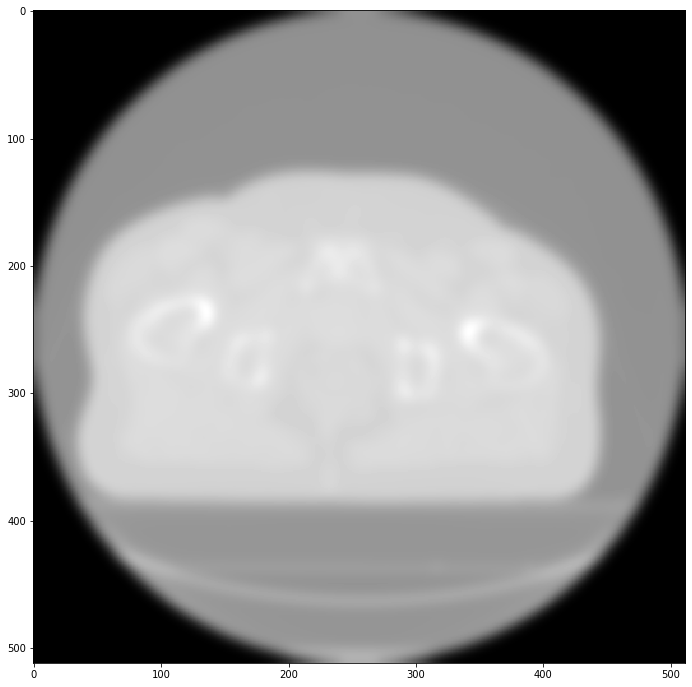

In [121]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(blur1, cmap="gray")
plt.show()

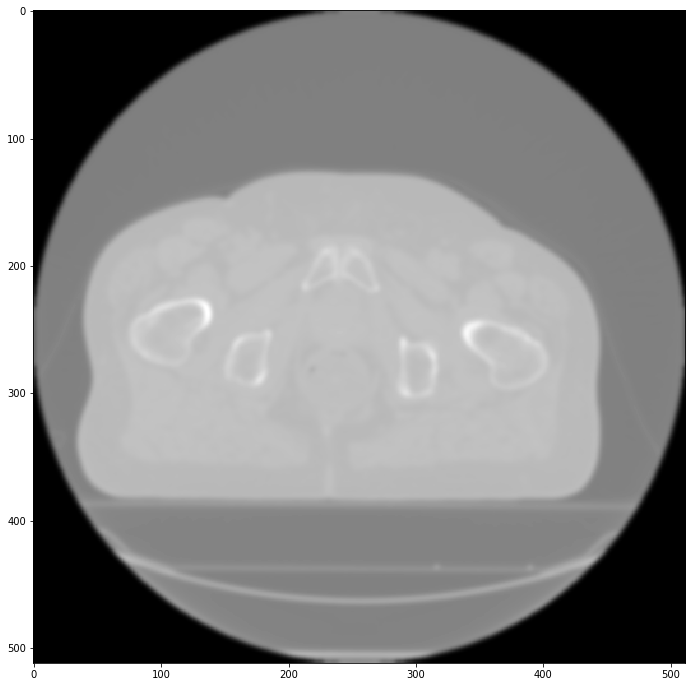

In [122]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(blur2, cmap="gray")
plt.show()

In [59]:
np.unique(target_label)

array([0, 4], dtype=uint8)

In [60]:
row_size = target_label.shape[0]
col_size = target_label.shape[1]

#for N in good_labels:
mask = np.where(target_label!=0,4,0)
interior = morphology.erosion(mask,np.ones([3,3])) # one last dilation 
contour = np.where(interior==0, 1, 0)
surface = contour*mask

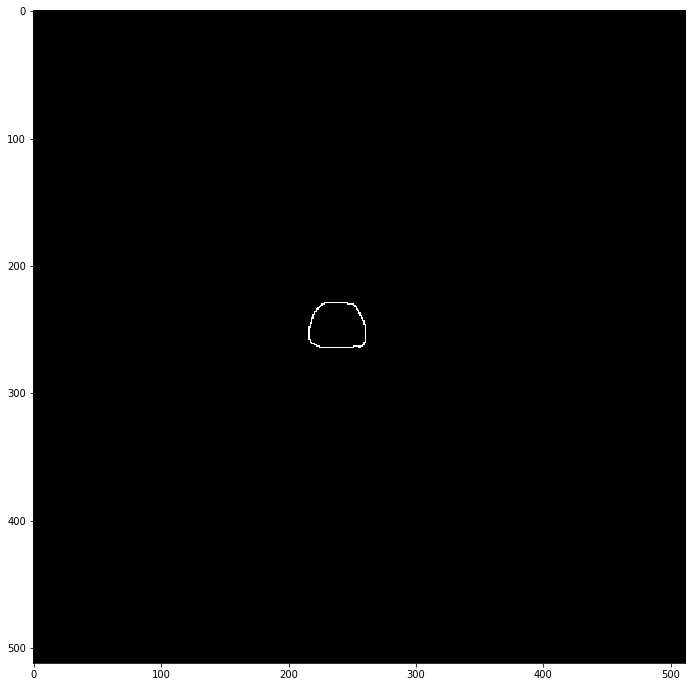

In [61]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(surface, cmap="gray")
plt.show()

In [62]:
def search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance):
    if vector[i] != 0:   
        if i-r > 0:
            if i-r < min(pos_current_distance):
                pos_current_distance.append(i-r)
                #pos_neighbor = vector[i]
                pos_neighbor = i
            
        elif i-r < 0:
            if abs(i-r) < min(neg_current_distance):
                neg_current_distance.append(abs(i-r))
                #neg_neighbor = vector[i]
                neg_neighbor = i
    return pos_neighbor, neg_neighbor

def nearest_neighbor_search(vector, r):
    pos_neighbor = 0
    neg_neighbor = 0
    pos_current_distance = [len(vector)]
    neg_current_distance = [len(vector)]
    for i in range(0, len(vector)-1):
        pos_neighbor, neg_neighbor = search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance)
    return pos_neighbor, neg_neighbor

In [126]:
def find_Fsd(k):
    #rand = np.random.random()
    #seed_value=int(100*rand+10000*k)
    #np.random.seed(seed_value)
    pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_x=norm.ppf(pRand_k, loc=0, scale=SD[0])
    Fsd_y=norm.ppf(pRand_k, loc=0, scale=SD[1])
    Fsd_z=norm.ppf(pRand_k, loc=0, scale=SD[2])
    Fsd_r = np.array([float(Fsd_x), float(Fsd_y), float(Fsd_z)])
    return Fsd_r

def find_Fct(roi, r, i, a, voxelsize, dist):
    gradct = (roi[r+1,i]-roi[r-1, i])/(dist*voxelsize)
    gradct_x = gradct[0]
    gradct_y = gradct[1]
    gradct_z = gradct[2]
    Fct_x = a/(np.abs(gradct_x)+a)
    Fct_y = a/(np.abs(gradct_y)+a)
    Fct_z = a/(np.abs(gradct_z)+a)
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r
        
def find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize):
    Fct_x = neg_Fct_r[0] + (pos_Fct_r[0] - neg_Fct_r[0])/((pos_r - neg_r)*voxelsize[0])*((r - neg_r)*voxelsize[0])
    Fct_y = neg_Fct_r[1] + (pos_Fct_r[1] - neg_Fct_r[1])/((pos_r - neg_r)*voxelsize[1])*((r - neg_r)*voxelsize[1])
    Fct_z = neg_Fct_r[2] + (pos_Fct_r[2] - neg_Fct_r[2])/((pos_r - neg_r)*voxelsize[2])*((r - neg_r)*voxelsize[2])
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r

def find_D(Fsd_r, Fct_r):
    Fct_x =  Fct_r[0]
    Fct_y =  Fct_r[1]
    Fct_z =  Fct_r[2]
    Fsd_x =  Fsd_r[0]
    Fsd_y =  Fsd_r[1]
    Fsd_z =  Fsd_r[2]
    D_x = Fsd_x*Fct_x
    D_y = Fsd_y*Fct_y
    D_z = Fsd_z*Fct_z
    D_r = [float(D_x), float(D_y), float(D_z)]
    return D_r

def r_to_xyz(F):
    F_x =  F[0]
    F_y =  F[1]
    F_z =  F[2]
    return F_x, F_y, F_z

In [124]:
def assd(slices, contour, k, voxelsize, a, dist, SD, surface, interior):
    roi=slices*contour
    dim=roi.shape[0]
    mat = np.ndarray([dim, dim],dtype=np.float64)
    dx = np.zeros((512, 512))
    dy = np.zeros((512, 512))
    dz = np.zeros((512, 512))
    D = []
    for i in range(0,dim-1):
        for r in range(0,dim-1):
            if  roi[r, i] != 0 and surface[r, i] != 0:
                Fsd_r = find_Fsd(k)
                Fct_r = find_Fct(roi, r, i, a, voxelsize, dist)
                D_r = find_D(Fsd_r, Fct_r)
                D_x, D_y, D_z = r_to_xyz(D_r)
                dx[r, i] = D_x
                dy[r, i] = D_y
                dz[r, i] = D_z
                D.append(D_r)
                roi[r, i] = 1
            
            elif roi[r, i] != 0 and interior[r, i] != 0:
                pos_r, neg_r = nearest_neighbor_search(surface[r], i)
                if pos_r > neg_r:
                    Fsd_r =  find_Fsd(k)
                    pos_Fct_r = find_Fct(roi, pos_r, i, a, voxelsize, dist)
                    neg_Fct_r = find_Fct(roi, neg_r, i, a, voxelsize, dist)
                    pos_Fct_x, pos_Fct_y, pos_Fct_z = r_to_xyz(pos_Fct_r)
                    neg_Fct_x, neg_Fct_y, neg_Fct_z = r_to_xyz(neg_Fct_r)
                    Fct_r = find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize)
                    D_r = find_D(Fsd_r, Fct_r)
                    D.append(D_r)
                    D_x, D_y, D_z = r_to_xyz(D_r)
                    dx[r, i] = D_x
                    dy[r, i] =  D_y
                    dz[r, i] = D_z
        
                    roi[r, i] = 0
            
    return D, dx, dy, dz, roi

In [127]:
#roi = target_label*target_img
k=1
a=50
dist=2
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
SD=[1.7, 2, 2.5]
assd_mask, dx, dy, dz, roi_new = assd(target_img, mask, k, voxelsize, a, dist, SD, surface, interior)

In [128]:
roi_cord = np.argwhere(mask != 0)
x = []
y = []
z = []
for i in roi_cord.tolist():
    x.append(i[0])
    y.append(i[1])
    z.append(1)
x = np.array(x)
y = np.array(y)
z = np.array(z)

In [129]:
u = []
v = []
w = []
u_cord = np.argwhere(dx != 0)
v_cord = np.argwhere(dy != 0)
w_cord = np.argwhere(dz != 0)

for i in u_cord.tolist():
    u.append(dx[i[0], i[1]])
for i in v_cord.tolist():
    v.append(dy[i[0], i[1]])
for i in w_cord.tolist():
    w.append(dy[i[0], i[1]])
    
u = np.array(u)
v = np.array(v)
w = np.array(w)

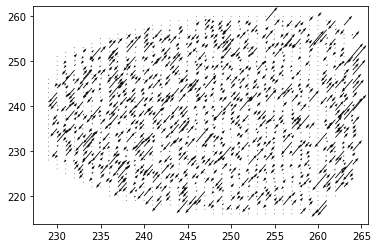

In [130]:
fig,ax = plt.subplots()
ax.quiver(x, y, u, v)
plt.show()

In [131]:
DU_mask = np.zeros((512,512))
x_new = x + v
y_new = y + u
for i in range(len(x_new)-1):
    DU_mask[int(round(x_new[i], 0)), int(round(y_new[i], 0))] = 1
    DU_mask[int(x[i]), int(y[i])] = 1

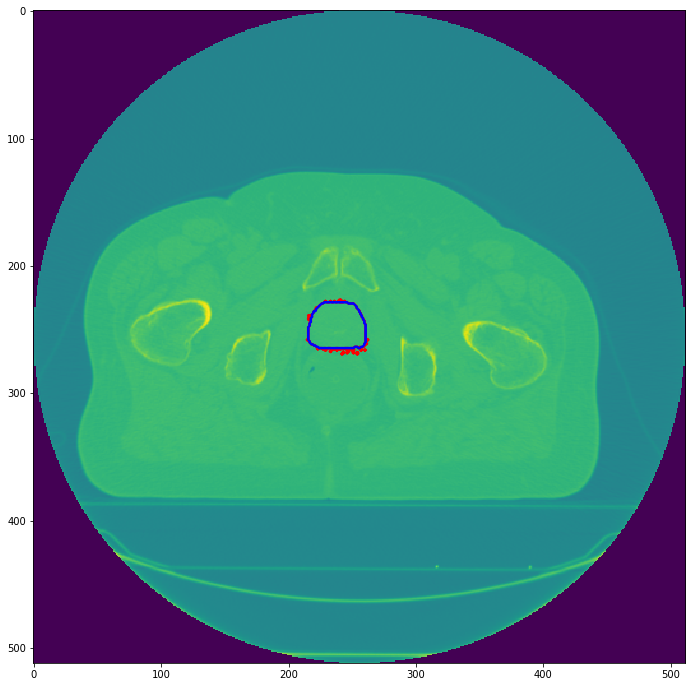

In [132]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
plt.imshow(target_img)
ax.contour(DU_mask, colors="red")
ax.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             #label='Quiver key, length = 10', labelpos='E')
plt.show()

In [133]:
#gaussian kde
from scipy.stats import kde
np.random.seed(1977)

x, y = x_new, y_new
nbins = 10

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(np.array([x_new, y_new]))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

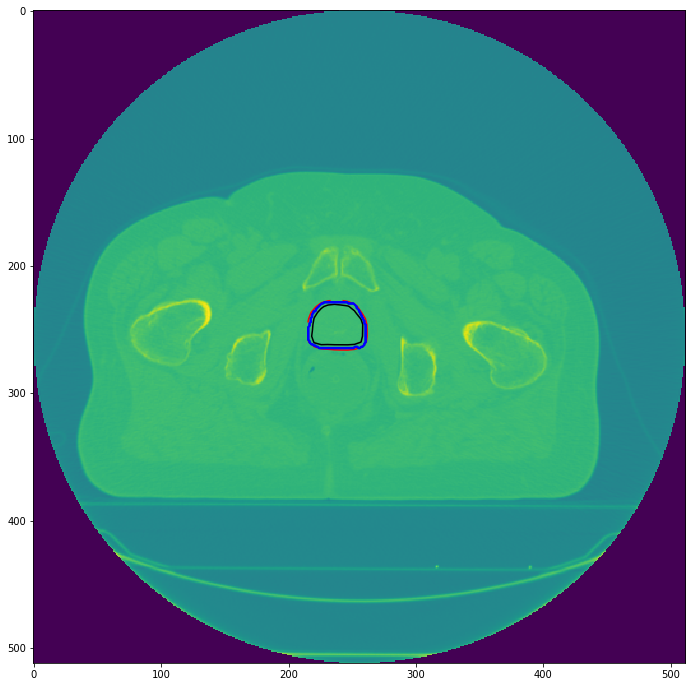

In [134]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
plt.imshow(target_img)
#ax.scatter(y_new, x_new, color="r", s=2)
ax.contour(yi, xi, zi.reshape(xi.shape), levels=2, colors=('black', 'red', 'black', 'black'))
ax.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")

plt.show()

In [112]:
import random
def find_pq(Qi ,i):
    phi_qx = random.randint(0, 2*pi)
    phi_qy = random.randint(0, 2*pi)
    phi_qz = random.randint(0, 2*pi)
    
    mq = 1 #2 or 3
    Qx=Qi[0]
    Qy=Qi[1]
    Qz=Qi[2]
    Pq_x = sin(2*math.pi*(i/Qx)*mq + phi_qx)
    Pq_y = sin(2*math.pi*(i/Qy)*mq + phi_qy)
    Pq_z = sin(2*math.pi*(i/Qz)*mq + phi_qz)
    PQ_r = [float(Pq_x), float(Pq_y), float(Pq_z)]
    
    return PQ_r

In [110]:
def find_D2(Fsd_r, Fct_r, pq_r):
    Fct_x =  Fct_r[0]
    Fct_y =  Fct_r[1]
    Fct_z =  Fct_r[2]
    Fsd_x =  Fsd_r[0]
    Fsd_y =  Fsd_r[1]
    Fsd_z =  Fsd_r[2]
    pq_x = pq_r[0]
    pq_y = pq_r[1]
    pq_z = pq_r[2]
    D_x = Fsd_x*Fct_x*q_x
    D_y = Fsd_y*Fct_y*q_y
    D_z = Fsd_z*Fct_z*q_z
    D_r = [float(D_x), float(D_y), float(D_z)]
    return D_r

In [ ]:
def assd(slices, contour, k, voxelsize, a, SD, surface, interior):
    roi=slices*contour
    dim=roi.shape[0]
    mat = np.ndarray([dim, dim],dtype=np.float64)
    dx = np.zeros((512, 512))
    dy = np.zeros((512, 512))
    dz = np.zeros((512, 512))
    D = []
    Q_r = find_Q(surface)
    for r in range(0,dim-1):
        for i in range(0,dim-1):
            if  roi[r, i] != 0 and surface[r, i] != 0:
                Fsd_r = find_Fsd(k)
                Fct_r = find_Fct(roi, r, c, a, voxelsize, dist)
                Qi_r=Q_r[i]
                PQ_r = find_pq(i, Qi_r)
                D_r = find_D2(Fsd_r, Fct_r, PQ_r)
                D_x, D_y, D_z = r_to_xyz(D_r)
                dx[r, i] = D_x
                dy[r, i] = D_y
                dz[r, i] = D_z
                D.append(D_r)
                roi[r, i] = 1
            
            elif roi[r, i] != 0 and interior[r, i] != 0:
                pos_r, neg_r = nearest_neighbor_search(surface[r], i)
                if pos_r > neg_r:
                    Fsd_r =  find_Fsd(k)
                    pos_Fct_r = find_Fct(roi, pos_r, i, a, voxelsize, dist)
                    neg_Fct_r = find_Fct(roi, neg_r, i, a, voxelsize, dist)
                    pos_Fct_x, pos_Fct_y, pos_Fct_z = r_to_xyz(pos_Fct_r)
                    neg_Fct_x, neg_Fct_y, neg_Fct_z = r_to_xyz(neg_Fct_r)
                    Fct_r = find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize)
                    Qi_r=Q_r[i]
                    PQ_r = find_pq(i, Qi)
                    D_r = find_D2(Fsd_r, Fct_r, PQ_r)
                    D.append(D_r)
                    D_x, D_y, D_z = r_to_xyz(D_r)
                    dx[r, i] = D_x
                    dy[r, i] =  D_y
                    dz[r, i] = D_z
                    roi[r, i] = 0
            
    return D, dx, dy, dz, roi

In [118]:
def find_Q():
    ##sort (x,y,z)
    return Q_r